Using the other object as test set 🤪

In [2]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

# Två delar:
# 1: fixa segmentstorleken
# 2: fixa masker för varje segment
# Eller egentligen, skit i det. Applicera masken i förväg?

objectwidth = 100
objectheight = 100
xspacing = 116
yspacing = 300
xstart = 293
ystart = 445
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 225
vsegments = [0, 150, 187, endlayer]
porositythreshold = 0.10

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])

objectinfo = pd.read_csv('Parameters2.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)

objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)
objectinfo.reset_index(drop=True, inplace=True)

objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

for index, object in objectinfo.iterrows():
    objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

rtn = np.full(objects.shape, np.nan)
aggregate = np.sum(objects, axis=(0))

emptyRatio = 30
limit = np.percentile(aggregate, emptyRatio)
testmask = aggregate >= limit
for object in objects:
    object[~testmask] = np.nan

# Create the good frame
segmentdf = pd.read_csv('Segments2.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity"])
segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
# segmentdf.drop(segmentdf[(segmentdf.VED > 50)].index, inplace=True)
segmentdf.reset_index(drop=True, inplace=True)
vs = [[vsegments[j], vsegments[j+1]] for i in range(0, len(objects)) for j in reversed(range(0, len(vsegments)-1))]
coorddf = pd.DataFrame(vs, columns=['zstart', 'zend'])
testobjectinfo = coorddf.join(segmentdf)
testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend] for index, object in testobjectinfo.iterrows()]

del objects
del objectinfo
del coorddf
del objectCoordinates
del paths_sorted
del integrals

In [ ]:
for i in range(0, 10):
    plt.imshow(testobjects[i][0])
    plt.title("Segment " + str(testobjectinfo.iloc[i].Segment) + " object " + str(testobjectinfo.iloc[i].Object) + " porosity " + str(testobjectinfo.iloc[i].Porosity) + " label " + str(testobjectinfo.iloc[i].Label))
    plt.figure()

In [3]:
# Read train data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
hsegments = [0,26,50,74,98,122]
powderthickness = 80
endlayer = 187
separate_test = True
objectsplit = 1
upsamplingratio = 1
positive_multiplier = 1
porositythreshold = 0.10

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)

objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

for index, object in objectinfo.iterrows():
    objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

aggregate = np.sum(objects, axis=(0,1))

emptyRatio = 47
limit = np.percentile(aggregate, emptyRatio)
mask = aggregate >= limit
mask = np.repeat([mask], endlayer, 0)

for object in objects:
    object[~mask] = np.nan

# Time to construct the "real" dataframe

segmentdf = pd.read_csv('Segments.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity", "Area"])
segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
originalframe = segmentdf.copy()
hs = [[hsegments[j], hsegments[j+1]] for i in range(0, len(objects)) for j in range(0, len(hsegments)-1)]
coorddf = pd.DataFrame(hs, columns=['hstart', 'hend'])
segmentdf = coorddf.join(segmentdf)

# Start of object multiplication 
layersPerObject = endlayer // objectsplit
testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
zs = [segmentdf.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
testzs = [segmentdf.copy().assign(zstart=testEnd, zend=endlayer)]
trainobjectinfo = pd.concat(zs, ignore_index=True)
trainobjectinfo.drop(trainobjectinfo[(trainobjectinfo.Objectnumber == 28) | (trainobjectinfo.Objectnumber == 21) ].index, inplace=True)
trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo = testobjectinfo if separate_test else pd.concat(testzs, ignore_index=True)

# Removes extra rows 
trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]

trainobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in trainobjectinfo.iterrows()]
testobjects = testobjects if separate_test else [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in testobjectinfo.iterrows()]

del aggregate
del limit
del integrals
del block
del paths
del zs
del coorddf
del objectCoordinates
del objectinfo

# assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [ ]:
for i in range(0, 10):
    plt.imshow(trainobjects[i][0])
    plt.title("Segment: " + str(trainobjectinfo.iloc[i].Segment) + " object " + str(trainobjectinfo.iloc[i].Object) + " porosity " + str(trainobjectinfo.iloc[i].Porosity) + " label " + str(trainobjectinfo.iloc[i].Label))
    plt.figure()

<Figure size 432x288 with 0 Axes>

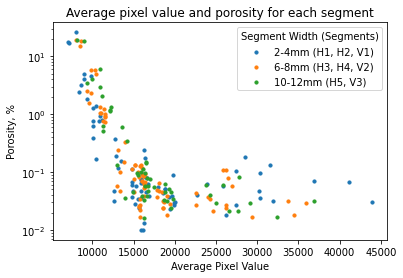

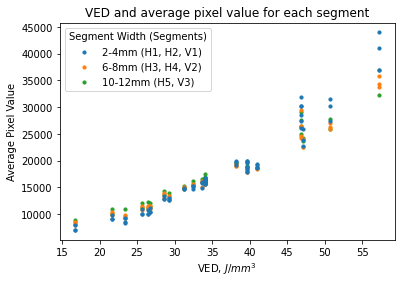

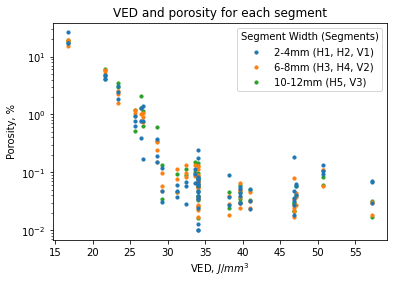

<Figure size 432x288 with 0 Axes>

In [15]:
# Create a numpy array with the average value of all non-nan pixels
X = np.array([np.nanmean(object) for object in trainobjects])
X1 = np.array([np.nanstd(object) for object in trainobjects])
X2 = np.array([np.nanmean(object) for object in testobjects])
X3 = np.array([np.nanstd(object) for object in testobjects])
Xs = np.concatenate((X.reshape(-1, 1), X1.reshape(-1, 1)), axis=1)
XTest = np.concatenate((X2.reshape(-1, 1), X3.reshape(-1, 1)), axis=1)

segments = 'H' + trainobjectinfo.Segment.astype(str)
    
plt.title("Average pixel value and porosity for each segment")
plt.ylabel('Porosity, %')
plt.xlabel('Average Pixel Value')
Y = trainobjectinfo.Porosity
Y2 = testobjectinfo.Porosity

x1 = X[trainobjectinfo.Segment == 1]
y1 = Y[trainobjectinfo.Segment == 1]
x2 = X[trainobjectinfo.Segment == 2]
y2 = Y[trainobjectinfo.Segment == 2]
x3 = X[trainobjectinfo.Segment == 3]
y3 = Y[trainobjectinfo.Segment == 3]
x4 = X[trainobjectinfo.Segment == 4]
y4 = Y[trainobjectinfo.Segment == 4]
x5 = X[trainobjectinfo.Segment == 5]
y5 = Y[trainobjectinfo.Segment == 5]
x6 = X2[testobjectinfo.Segment == 1]
y6 = Y2[testobjectinfo.Segment == 1]
x7 = X2[testobjectinfo.Segment == 2]
y7 = Y2[testobjectinfo.Segment == 2]
x8 = X2[testobjectinfo.Segment == 3]
y8 = Y2[testobjectinfo.Segment == 3]

plt.scatter([x1, x2, x6], [y1, y2, y6], s=10, label='2-4mm (H1, H2, V1)')
plt.scatter([x3, x4, x7], [y3, y4, y7], s=10, label='6-8mm (H3, H4, V2)')
plt.scatter([x5, x8], [y5, y8], s=10, label='10-12mm (H5, V3)')
# plt.scatter(x4, y4, s=10, label='H4')
# plt.scatter(x5, y5, s=10, label='H5')
# plt.scatter(x6, y6, s=10, label='V1')
# plt.scatter(x7, y7, s=10, label='V2')
# plt.scatter(x8, y8, s=10, label='V3')
plt.legend(loc="upper right", title="Segment Width (Segments)")
# legend1 = plt.legend(*scatter.legend_elements(),
#                     loc="upper right", title="Segment")
# plt.axline((20000, porositythreshold), (20001, porositythreshold), linewidth=1, color='b')
# for index, row in segmentdf.iterrows():
#     plt.annotate(text=row.Object, xy=(x[index], y[index]))
plt.yscale('log')
plt.savefig('otporosity.png', dpi=300)
plt.figure()

Y = X
Y2 = X2

X = trainobjectinfo.VED
X2 = testobjectinfo.VED

x1 = X[trainobjectinfo.Segment == 1]
y1 = Y[trainobjectinfo.Segment == 1]
x2 = X[trainobjectinfo.Segment == 2]
y2 = Y[trainobjectinfo.Segment == 2]
x3 = X[trainobjectinfo.Segment == 3]
y3 = Y[trainobjectinfo.Segment == 3]
x4 = X[trainobjectinfo.Segment == 4]
y4 = Y[trainobjectinfo.Segment == 4]
x5 = X[trainobjectinfo.Segment == 5]
y5 = Y[trainobjectinfo.Segment == 5]
x6 = X2[testobjectinfo.Segment == 1]
y6 = Y2[testobjectinfo.Segment == 1]
x7 = X2[testobjectinfo.Segment == 2]
y7 = Y2[testobjectinfo.Segment == 2]
x8 = X2[testobjectinfo.Segment == 3]
y8 = Y2[testobjectinfo.Segment == 3]

plt.scatter([x1, x2, x6], [y1, y2, y6], s=10, label='2-4mm (H1, H2, V1)', zorder=3)
plt.scatter([x3, x4, x7], [y3, y4, y7], s=10, label='6-8mm (H3, H4, V2)', zorder = 2)
plt.scatter([x5, x8], [y5, y8], s=10, label='10-12mm (H5, V3)', zorder=1)
plt.legend(loc="upper left", title="Segment Width (Segments)")
plt.title("VED and average pixel value for each segment")
plt.xlabel('VED, $J/mm^3$')
plt.ylabel('Average Pixel Value')
plt.savefig('vedot.png', dpi=300)
plt.figure()

Y = trainobjectinfo.Porosity
Y2 = testobjectinfo.Porosity

X = trainobjectinfo.VED
X2 = testobjectinfo.VED

x1 = X[trainobjectinfo.Segment == 1]
y1 = Y[trainobjectinfo.Segment == 1]
x2 = X[trainobjectinfo.Segment == 2]
y2 = Y[trainobjectinfo.Segment == 2]
x3 = X[trainobjectinfo.Segment == 3]
y3 = Y[trainobjectinfo.Segment == 3]
x4 = X[trainobjectinfo.Segment == 4]
y4 = Y[trainobjectinfo.Segment == 4]
x5 = X[trainobjectinfo.Segment == 5]
y5 = Y[trainobjectinfo.Segment == 5]
x6 = X2[testobjectinfo.Segment == 1]
y6 = Y2[testobjectinfo.Segment == 1]
x7 = X2[testobjectinfo.Segment == 2]
y7 = Y2[testobjectinfo.Segment == 2]
x8 = X2[testobjectinfo.Segment == 3]
y8 = Y2[testobjectinfo.Segment == 3]

plt.scatter([x1, x2, x6], [y1, y2, y6], s=10, label='2-4mm (H1, H2, V1)', zorder=3)
plt.scatter([x3, x4, x7], [y3, y4, y7], s=10, label='6-8mm (H3, H4, V2)', zorder = 2)
plt.scatter([x5, x8], [y5, y8], s=10, label='10-12mm (H5, V3)', zorder=1)
plt.legend(loc="upper right", title="Segment Width (Segments)")
plt.xlabel('VED, $J/mm^3$')
plt.ylabel('Porosity, %')
plt.yscale('log')
plt.title("VED and porosity for each segment")
plt.savefig('vedporosity.png', dpi=300)
plt.figure()

In [ ]:
for index, object in enumerate(trainobjects):
    if trainobjectinfo.iloc[index].Segment != 5:
        continue
    plt.imshow(object[0])
    plt.figure()

<Figure size 432x288 with 0 Axes>

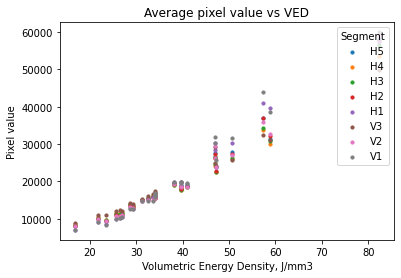

<Figure size 432x288 with 0 Axes>

In [63]:
Y3 = trainobjectinfo.VED
Y4 = testobjectinfo.VED

y1 = Y3[trainobjectinfo.Segment == 1]
y2 = Y3[trainobjectinfo.Segment == 2]
y3 = Y3[trainobjectinfo.Segment == 3]
y4 = Y3[trainobjectinfo.Segment == 4]
y5 = Y3[trainobjectinfo.Segment == 5]
y6 = Y4[testobjectinfo.Segment == 1]
y7 = Y4[testobjectinfo.Segment == 2]
y8 = Y4[testobjectinfo.Segment == 3]

plt.title("Average pixel value vs VED")
plt.ylabel('Pixel value')
plt.xlabel('Volumetric Energy Density, J/mm3')
plt.scatter(y5, x5, s=10, label='H5')
plt.scatter(y4, x4, s=10, label='H4')
plt.scatter(y3, x3, s=10, label='H3')
plt.scatter(y2, x2, s=10, label='H2')
plt.scatter(y1, x1, s=10, label='H1')
plt.scatter(y8, x8, s=10, label='V3')
plt.scatter(y7, x7, s=10, label='V2')
plt.scatter(y6, x6, s=10, label='V1')
plt.legend(loc="upper right", title="Segment")
# legend1 = plt.legend(*scatter.legend_elements(),
#                     loc="upper right", title="Segment")
# for index, row in segmentdf.iterrows():
#     plt.annotate(text=row.Object, xy=(x[index], y[index]))
# plt.yscale('log')
plt.figure()

In [139]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
import warnings

def preprocess(objects, type, sharpening):
    rtn = []
    # print(rtn.shape)
    for index, object in enumerate(objects):
        sharpened = object
        if(sharpening != 'none'):
            sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
            sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            rtn.append(xs)
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            avg = np.nanmean(xs)
            stddev = np.nanstd(xs)
            xs = (xs - avg) / avg
            rtn.append(xs)
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    # c, z, y, x = objects.shape

    outlierValues = []
    index = 0
    # return objects
    for object in objects:
        z, y, x = object.shape
        # Step 1: calculate neighbourhood
        neighbourkernel = np.array(
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        )/9 if neighbourhoodSetting == 'grid' else np.array(
            [[1, 2,  1],
            [2, 4, 2],
            [1, 2,  1]])/16
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        ys = neighbourhoodValues[0:z-windowSize+1]
        xs = object[offset:z-endoffset]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        # plt.imshow(xs[0])
        # plt.figure()
        # plt.imshow(xs[0])
        # plt.figure()
        # if(index == 58):
        #     plt.imshow(xs[0])
        #     plt.figure()
        #     plt.imshow(ys[0])
        #     plt.figure()
        #     plt.imshow(filter[0])
        #     plt.figure()
        #     print(len(np.unique(filter)))
        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues.append(outliers)
        else:
            with warnings.catch_warnings():
                line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                p = np.poly1d(line)
                outlierValues.append(p(xs) - ys)
            # plt.scatter(xs[filter].flatten(), ys[filter].flatten())
            # plt.axline((-0.1, p(-0.1)), (0, p(0)), linewidth=2, color='b')
            # plt.figure()
            assert(xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        index+=1
    # print("okidk ", np.average(np.isfinite(outlierValues)))
    # assert(np.average(np.isfinite(outlierValues)) > 0.4)
    return outlierValues

def encode(outlierobjects, type, buckets, histnormalise, minval=0, maxval=0, transformer=None):
    numberOfObjects = len(outlierobjects)
    X = np.full((numberOfObjects, buckets), np.nan)
    raw = np.concatenate([oo.flatten() for oo in outlierobjects])
    filter = np.isfinite(raw)
    minval = np.min(raw[filter]) if minval == 0 else minval
    maxval = np.max(raw[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    return X, minval, maxval, edges, transformer

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, histnormalise):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform")
    if (histnormalise == True):
        clf = Pipeline([('scaler', RobustScaler()), ('classifier', clf)])
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict(Xtest)
    # graph = (clf['classifier'] if histnormalise == True else clf).kneighbors(Xtest, return_distance=False)
    # print(graph)
    # print(yfit)
    return cvs.mean(), metrics.roc_auc_score(Ytest, yfit), metrics.precision_score(Ytest, yfit, zero_division=0), metrics.recall_score(Ytest, yfit, zero_division=0)

In [4]:
# parameter settings
types = ['scatter', 'spatstat', 'moran', ]
sharpening = ['none', 'direct', 'diagonal']
windowsizes = [1, 3, 5, 7]
neighbourhoodSetting = ['grid', 'euclidean']
bins = [30, 60, 90, 120, 150]
histnormalise = [True, False]
k = [3,4,5,10,15,20]

In [3]:
# Narrow settings for iterating
types = ['scatter', 'spatstat', 'moran']
sharpening = ['none']
windowsizes = [1, 3, 5]
neighbourhoodSetting = ['grid']
bins = [5,10,20,40]
histnormalise = [True, False]
k = [5,10,15]

In [154]:
# Now to tie it all together...
def doStuff ():
    columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'cv-auc', 'test-auc', 'test-precision', 'test-recall']
    results = pd.DataFrame(columns=columns)
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    for type in types:
        for sharpSetting in sharpening:
            print(datetime.now().strftime("%H:%M:%S"), "Processing type: ", type, " sharpening: ", sharpSetting)
            # trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
            trainpreprocessed =preprocess(trainobjects, type, sharpSetting)
            testpreprocessed =preprocess(testobjects, type, sharpSetting)
            # plt.imshow(trainobjects[0][0])
            # plt.title("train 0,0")
            # plt.figure()
            # plt.imshow(testobjects[0][0])
            # plt.title("test 0,0")
            # plt.figure()
            # plt.imshow(trainpreprocessed[0][0])
            # plt.title("trainpreprocessed 0,0")
            # plt.figure()
            # plt.imshow(testpreprocessed[0][0])
            # plt.title("testpreprocessed 0,0")
            # plt.figure()
            for windowsize in windowsizes:
                for nSetting in neighbourhoodSetting:
                    print(datetime.now().strftime("%H:%M:%S"), "Processing windowSize: ", windowsize, " neighbourhood: ", nSetting)
                    # trainoutliers = np.apply_along_axis(calculateoutliers, 1, trainpreprocessed, type, nSetting, windowsize)
                    trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
                    testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)

                    # plt.imshow(trainoutliers[0][0])
                    # plt.title("trainoutliers 0,0")
                    # plt.figure()
                    # plt.imshow(testoutliers[0][0])
                    # plt.title("testoutliers 0,0")
                    # plt.figure()
                    for histnorm in histnormalise:
                        for bincount in bins:
                            print(datetime.now().strftime("%H:%M:%S"), "Processing histnorm: ", histnorm, " bins: ", bincount)
                            Xtrain, minval, maxval, edges, transformer = encode(trainoutliers, type, bincount, histnorm)
                            Xtest, _, _, _, _ = encode(testoutliers, type, bincount, histnorm, minval=minval, maxval=maxval, transformer=transformer)
                            # plt.hist(edges[0:-1], weights=Xtrain[0], bins=edges)
                            # plt.yscale('log')
                            # plt.figure()
                            # plt.hist(edges[0:-1], weights=Xtest[0], bins=edges)
                            # plt.yscale('log')
                            # plt.figure()
                            # Add encode for test as well
                            for n_neighbors in k:
                                cvscore, score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, histnorm)
                                nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bincount, histnorm, n_neighbors, cvscore, score, precision, recall]], columns=columns)
                                results = pd.concat([results, nextRow])
                            results.to_csv('result-010-3.csv', index=False, header=True)
            # return
doStuff()

13:21:02 Processing type:  scatter  sharpening:  none
13:21:02 Processing windowSize:  1  neighbourhood:  grid


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutli

13:21:18 Processing histnorm:  True  bins:  5
13:21:21 Processing histnorm:  True  bins:  10
13:21:23 Processing histnorm:  True  bins:  20
13:21:25 Processing histnorm:  False  bins:  5
13:21:26 Processing histnorm:  False  bins:  10
13:21:28 Processing histnorm:  False  bins:  20
13:21:29 Processing windowSize:  3  neighbourhood:  grid


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutli

13:21:43 Processing histnorm:  True  bins:  5
13:21:44 Processing histnorm:  True  bins:  10
13:21:46 Processing histnorm:  True  bins:  20
13:21:47 Processing histnorm:  False  bins:  5
13:21:49 Processing histnorm:  False  bins:  10
13:21:50 Processing histnorm:  False  bins:  20
13:21:52 Processing windowSize:  5  neighbourhood:  grid


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_76230/271704445.py:30: RankWarning: Polyfit may be poorly conditioned
  testoutliers = calculateoutli

13:22:05 Processing histnorm:  True  bins:  5
13:22:06 Processing histnorm:  True  bins:  10
13:22:08 Processing histnorm:  True  bins:  20
13:22:09 Processing histnorm:  False  bins:  5
13:22:10 Processing histnorm:  False  bins:  10
13:22:12 Processing histnorm:  False  bins:  20
13:22:13 Processing type:  spatstat  sharpening:  none
13:22:14 Processing windowSize:  1  neighbourhood:  grid
13:22:23 Processing histnorm:  True  bins:  5
13:22:25 Processing histnorm:  True  bins:  10
13:22:27 Processing histnorm:  True  bins:  20
13:22:28 Processing histnorm:  False  bins:  5
13:22:30 Processing histnorm:  False  bins:  10
13:22:31 Processing histnorm:  False  bins:  20
13:22:33 Processing windowSize:  3  neighbourhood:  grid
13:22:42 Processing histnorm:  True  bins:  5
13:22:44 Processing histnorm:  True  bins:  10
13:22:46 Processing histnorm:  True  bins:  20
13:22:47 Processing histnorm:  False  bins:  5
13:22:48 Processing histnorm:  False  bins:  10
13:22:50 Processing histnorm: 

In [85]:
np.average(trainobjectinfo['Label'])

0.425531914893617

In [ ]:
type = "scatter"
sharpSetting = "none"
windowsize = 3
histnorm = "none"
bucket = 30
nSetting = "euclidean"

testpreprocessed =preprocess(testobjects, type, sharpSetting)
testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)

0.81875 0.875 0.7
0.81875 0.875 0.7
0.81875 0.875 0.7


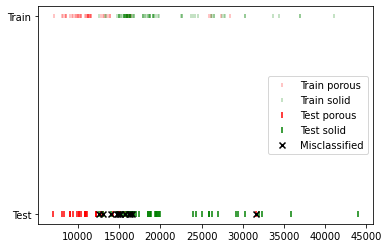

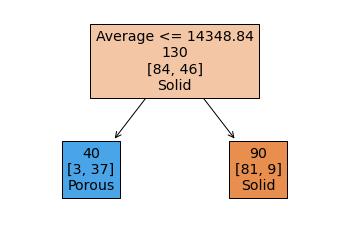

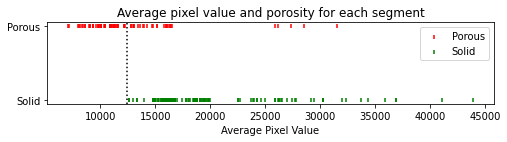

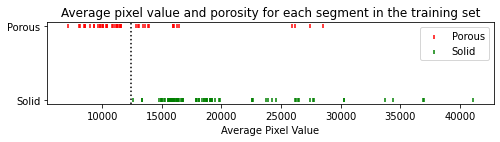

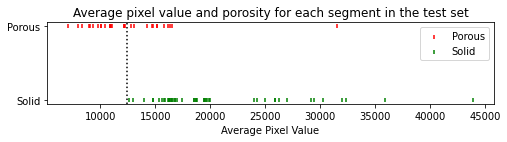

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors, metrics
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay
Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
Ytest = np.array(testobjectinfo.loc[:,"Label"])

TrainMean = np.array([np.nanmean(object) for object in trainobjects])
TrainStd = np.array([np.nanstd(object) for object in trainobjects])
TestMean = np.array([np.nanmean(object) for object in testobjects])
TestStd = np.array([np.nanstd(object) for object in testobjects])
Xtrain = np.concatenate((TrainMean.reshape(-1, 1), TrainStd.reshape(-1, 1)), axis=1)
Xtest = np.concatenate((TestMean.reshape(-1, 1), TestStd.reshape(-1, 1)), axis=1)



clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
print(metrics.roc_auc_score(Ytest, Ypred), metrics.precision_score(testobjectinfo.Label, Ypred, zero_division=0), metrics.recall_score(testobjectinfo.Label, Ypred, zero_division=0))
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(TrainMean.reshape(-1, 1), Ytrain)
Ypred = clf.predict(TestMean.reshape(-1, 1))
print(metrics.roc_auc_score(Ytest, Ypred), metrics.precision_score(testobjectinfo.Label, Ypred, zero_division=0), metrics.recall_score(testobjectinfo.Label, Ypred, zero_division=0))
clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(TrainMean.reshape(-1, 1), Ytrain)
Ypred = clf.predict(TestMean.reshape(-1, 1))
print(metrics.roc_auc_score(Ytest, Ypred), metrics.precision_score(testobjectinfo.Label, Ypred, zero_division=0), metrics.recall_score(testobjectinfo.Label, Ypred, zero_division=0))
onetrain = np.ones(len(Ytrain))
zerotrain = np.zeros(len(Ytrain))
onetest = np.ones(len(Ytest))
zerotest = np.zeros(len(Ytest))


plt.scatter(TrainMean[Ytrain == 1], ones[Ytrain == 1], c='r', s=10, alpha=0.3, label='Train porous', marker = '|')
plt.scatter(TrainMean[Ytrain == 0], ones[Ytrain == 0], c='g', s=10, alpha=0.3, label='Train solid', marker = '|')
plt.scatter(TestMean[Ytest == 1], zeros[Ytest == 1], c='r', label='Test porous', marker = '|')
plt.scatter(TestMean[Ytest == 0], zeros[Ytest == 0], c='g', label='Test solid', marker = '|')
plt.scatter(TestMean[Ypred != Ytest], zeros[Ypred != Ytest], c='black', marker='x', label='Misclassified')
plt.yticks([0, 1], ['Test', 'Train'])
plt.legend()
plt.figure()
tree.plot_tree(clf, feature_names=['Average'], class_names=['Solid', 'Porous'], filled=True, impurity=False, label='none')

f = plt.figure()
plt.title("Average pixel value and porosity for each segment")
f.set_figwidth(8)
f.set_figheight(1.5)
plt.scatter(np.concatenate([TrainMean[Ytrain == 1], TestMean[Ytest == 1]], axis=0), np.concatenate([onetrain[Ytrain == 1], onetest[Ytest == 1]], axis=0), c='r', s=10, marker="|", label='Porous')
plt.scatter(np.concatenate([TrainMean[Ytrain == 0], TestMean[Ytest == 0]], axis=0), np.concatenate([zerotrain[Ytrain == 0], zerotest[Ytest == 0]], axis=0), c='g', s=10, marker="|", label='Solid')
plt.yticks([0, 1], ['Solid', 'Porous'])
plt.axline((12400, 0), (12400, 1), color='black', linestyle='dotted')
plt.xlabel("Average Pixel Value")
plt.legend()

f = plt.figure()
plt.title("Average pixel value and porosity for each segment in the training set")
f.set_figwidth(8)
f.set_figheight(1.5)
plt.scatter(TrainMean[Ytrain == 1], onetrain[Ytrain == 1], c='r', s=10, marker="|", label='Porous')
plt.scatter(TrainMean[Ytrain == 0], zerotrain[Ytrain == 0], c='g', s=10, marker="|", label='Solid')
plt.yticks([0, 1], ['Solid', 'Porous'])
plt.axline((12400, 0), (12400, 1), color='black', linestyle='dotted')
plt.xlabel("Average Pixel Value")
plt.legend()

f = plt.figure()
plt.title("Average pixel value and porosity for each segment in the test set")
f.set_figwidth(8)
f.set_figheight(1.5)
plt.scatter(TestMean[Ytest == 1], onetest[Ytest == 1], c='r', s=10, marker="|", label='Porous')
plt.scatter(TestMean[Ytest == 0], zerotest[Ytest == 0], c='g', s=10, marker="|", label='Solid')
plt.yticks([0, 1], ['Solid', 'Porous'])
plt.axline((12400, 0), (12400, 1), color='black', linestyle='dotted')
plt.xlabel("Average Pixel Value")
plt.legend()